In [45]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/adni-extracted-axial/Axial/CI/CI128_S_1148a099.png
/kaggle/input/adni-extracted-axial/Axial/AD/AD136_S_0426a120.png
/kaggle/input/adni-extracted-axial/Axial/CN/CN018_S_0369a121.png


In [46]:
!pip install git+https://github.com/rwightman/pytorch-image-models.git

  Cloning https://github.com/rwightman/pytorch-image-models.git to /tmp/pip-req-build-0epm3sc8
  Running command git clone --filter=blob:none --quiet https://github.com/rwightman/pytorch-image-models.git /tmp/pip-req-build-0epm3sc8
  Resolved https://github.com/rwightman/pytorch-image-models.git to commit 2ec2f1aa73e3976553b1ddcb4245a42052a59138
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [47]:
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models
import torch
from tqdm.auto import tqdm
import numpy as np
import os
import sys
import cv2
import glob
import math
import time
import timm
import torch
import random
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
from torch import nn, optim
from torchinfo import summary
from tabulate import tabulate
from datetime import timedelta
from functools import lru_cache
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.image as mpimg
from torchvision import transforms
from PIL import Image, ImageEnhance
from joblib import Parallel, delayed
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import LambdaLR
from sklearn.preprocessing import LabelEncoder
from torchvision.transforms import Resize, ToTensor
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, confusion_matrix, classification_report
)

In [48]:
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

In [49]:
ds = ImageFolder('/kaggle/input/adni-extracted-axial/Axial', transform = transform)

In [50]:
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset, ConcatDataset

labels = [label for _, label in ds]

sss_train_test = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_indices_1, test_indices = next(sss_train_test.split(torch.zeros(len(labels)), labels))

# Create Subset objects for train and test sets
train_data_1 = Subset(ds, train_indices_1)
test_data = Subset(ds, test_indices)

# Extract labels from the train subset for train-validation split
train_labels_1 = [label for _, label in train_data_1]

# Perform stratified shuffle split for train and validation
sss_train_val = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_indices, val_indices = next(sss_train_val.split(torch.zeros(len(train_labels_1)), train_labels_1))

# Create Subset objects for train and validation sets
train_data = Subset(train_data_1, train_indices)
val_data = Subset(train_data_1, val_indices)

In [51]:
from collections import defaultdict

# Define a dictionary to store the counts of images in each class
train_class_counts = defaultdict(int)
val_class_counts = defaultdict(int)
test_class_counts = defaultdict(int)

# Iterate over train_data and count the occurrences of each class label
for _, label in train_data:
    train_class_counts[label] += 1

# Iterate over val_data and count the occurrences of each class label
for _, label in val_data:
    val_class_counts[label] += 1

# Iterate over test_data and count the occurrences of each class label
for _, label in test_data:
    test_class_counts[label] += 1

# Print the counts for train, val, and test datasets
print("Train Dataset Class Counts:")
for class_label, count in train_class_counts.items():
    print(f"Class {class_label}: {count} images")

print("\nValidation Dataset Class Counts:")
for class_label, count in val_class_counts.items():
    print(f"Class {class_label}: {count} images")

print("\nTest Dataset Class Counts:")
for class_label, count in test_class_counts.items():
    print(f"Class {class_label}: {count} images")


Train Dataset Class Counts:
Class 1: 1657 images
Class 2: 922 images
Class 0: 719 images

Validation Dataset Class Counts:
Class 1: 415 images
Class 2: 230 images
Class 0: 180 images

Test Dataset Class Counts:
Class 2: 288 images
Class 1: 518 images
Class 0: 225 images


In [52]:
device = torch.device('cuda')


In [53]:
device

device(type='cuda')

In [54]:
num_classes = 3

# Create the model
model = timm.create_model('pit_ti_224', pretrained=True)

# Modify the model's output head
model.head = torch.nn.Linear(model.head.in_features, num_classes)

# Move the model to the specified device
model.to(device)

# Print the model summary
summary(model, (3, 224, 224))  #

Layer (type:depth-idx)                             Output Shape              Param #
PoolingVisionTransformer                           [1, 3]                    46,720
├─ConvEmbedding: 1-1                               [64, 27, 27]              --
│    └─Conv2d: 2-1                                 [64, 27, 27]              49,216
├─Dropout: 1-2                                     [1, 64, 27, 27]           --
├─SequentialTuple: 1-3                             [1, 256, 7, 7]            --
│    └─Transformer: 2-2                            [1, 64, 27, 27]           --
│    │    └─Identity: 3-1                          [1, 730, 64]              --
│    │    └─Sequential: 3-2                        [1, 730, 64]              99,968
│    └─Transformer: 2-3                            [1, 128, 14, 14]          --
│    │    └─Pooling: 3-3                           [1, 128, 14, 14]          9,600
│    │    └─Identity: 3-4                          [1, 197, 128]             --
│    │    └─Sequenti

In [55]:
def custom_metrics(y_pred, y_true, loss):
    """
    Calculate custom evaluation metrics for multiclass classification.

    Args:
        y_pred (Tensor): Predicted probabilities for each class.
        y_true (Tensor): True labels.
        loss (float): Loss value.

    Returns:
        dict: Dictionary containing computed metrics.
    """
    # Calculate predicted class labels
    y_pred_classes = torch.argmax(y_pred, dim=1)

    # Calculate accuracy using predicted and true labels
    y_true_numpy = y_true.cpu().numpy()
    y_pred_classes_numpy = y_pred_classes.cpu().numpy()
    accuracy = accuracy_score(y_true_numpy, y_pred_classes_numpy)

    # Calculate precision, recall, and F1-score
    precision = precision_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    recall = recall_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    f1 = f1_score(y_true_numpy, y_pred_classes_numpy, average='weighted')

    # Compute confusion matrix for multiclass classification
    cm = confusion_matrix(y_true_numpy, y_pred_classes_numpy)
    
    # Calculate specificity, sensitivity, and MCC for multiclass classification
    tn = cm[0, 0]
    fp = cm[0, 1:].sum()
    fn = cm[1:, 0].sum()
    tp = cm[1:, 1:].sum()

    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    mcc = matthews_corrcoef(y_true_numpy, y_pred_classes_numpy)

    # Calculate AUC for each class
    num_classes = y_pred.shape[1]
    auc_scores = []

    for class_idx in range(num_classes):
        class_y_true = (y_true_numpy == class_idx).astype(np.float32)
        class_y_pred = y_pred[:, class_idx].cpu().numpy()
        auc_score = roc_auc_score(class_y_true, class_y_pred)
        auc_scores.append(auc_score)

    # Average AUC across classes
    auc_avg = np.mean(auc_scores)

    # Create a dictionary to store metrics
    metrics = {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "mcc": mcc,
        "auc": auc_avg,
    }

    return metrics

In [56]:
# Define the loss function and optimizer
from torch.optim.lr_scheduler import StepLR

# scheduler = StepLR(optimizer, step_size=8, gamma=0.95)

LR = 0.00095
BATCH_SIZE = 64

optimizer = torch.optim.Adam(model.parameters(), lr = LR)

criterion = torch.nn.CrossEntropyLoss() 
# criterion_DRW = torch.nn.CrossEntropyLoss(weight = weight)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [57]:
total_epochs = 50

# Initialize lists to store metric values for each epoch
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score", "specificity", "sensitivity", "mcc", "auc"]
train_metrics_history = {metric_name: [] for metric_name in metric_names}
val_metrics_history = {metric_name: [] for metric_name in metric_names}

# Training and validation loop
total_training_time = 0.0
total_validation_time = 0.0

for epoch in range(total_epochs):
    start_time = time.time()
    
    # Training phase
    model.train()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f"Training Model - Epoch [{epoch + 1}/{total_epochs}]")):
        data = data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        all_predictions.extend(torch.softmax(outputs, dim=1).cpu().detach().numpy())
        all_targets.extend(targets.cpu().numpy())

    end_time = time.time()
    epoch_training_time = end_time - start_time
    total_training_time += epoch_training_time
    average_loss = total_loss / len(train_loader)

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    train_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

    # Print training metrics in one line
    training_metrics_line = "Metrics - "
    for metric_name, metric_value in train_metrics.items():
        if metric_name == 'auc':
            training_metrics_line += f"{metric_name}: {metric_value:.4f}"
        else:
            training_metrics_line += f"{metric_name}: {metric_value:.4f}, "

    print(f"{training_metrics_line}")

    for metric_name in metric_names:
        train_metrics_history[metric_name].append(train_metrics[metric_name])

    # Validation phase
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    start_time = time.time()

    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(tqdm(val_loader, desc="Validating Model: ")):
            data = data.to(device)
            targets = targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            all_predictions.extend(torch.softmax(outputs, dim=1).cpu().detach().numpy())
            all_targets.extend(targets.cpu().numpy())

    end_time = time.time()
    epoch_validation_time = end_time - start_time
    total_validation_time += epoch_validation_time
    average_loss = total_loss / len(val_loader)

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    val_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

    # Print validation metrics in one line
    validation_metrics_line = "Metrics - "
    for metric_name, metric_value in val_metrics.items():
        if metric_name == 'auc':
            validation_metrics_line += f"{metric_name}: {metric_value:.4f}"
        else:
            validation_metrics_line += f"{metric_name}: {metric_value:.4f}, "

    print(f"{validation_metrics_line}")
    
    for metric_name in metric_names:
        val_metrics_history[metric_name].append(val_metrics[metric_name])
    
#     scheduler.step()

# Calculate and display total time taken for training and validation
print(f"Total Training Time: {str(timedelta(seconds=total_training_time))}")
print(f"Total Validation Time: {str(timedelta(seconds=total_validation_time))}")

# Calculate and display average time taken per epoch for training and validation
avg_training_time_per_epoch = total_training_time / total_epochs
avg_validation_time_per_epoch = total_validation_time / total_epochs
print(f"Average Training Time per Epoch: {str(timedelta(seconds=avg_training_time_per_epoch))}")
print(f"Average Validation Time per Epoch: {str(timedelta(seconds=avg_validation_time_per_epoch))}")

Training Model - Epoch [1/50]: 100%|██████████| 52/52 [00:17<00:00,  2.90it/s]


Metrics - loss: 1.1653, accuracy: 0.4739, precision: 0.3670, recall: 0.4739, f1_score: 0.3609, specificity: 0.0320, sensitivity: 0.9589, mcc: -0.0132, auc: 0.5058


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  3.72it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.0427, accuracy: 0.5030, precision: 0.2530, recall: 0.5030, f1_score: 0.3367, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.0000, auc: 0.6098


Training Model - Epoch [2/50]: 100%|██████████| 52/52 [00:18<00:00,  2.81it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.0410, accuracy: 0.4921, precision: 0.3235, recall: 0.4921, f1_score: 0.3481, specificity: 0.0000, sensitivity: 1.0000, mcc: -0.0087, auc: 0.5176


Validating Model: 100%|██████████| 13/13 [00:04<00:00,  3.24it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.0429, accuracy: 0.5030, precision: 0.2530, recall: 0.5030, f1_score: 0.3367, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.0000, auc: 0.6083


Training Model - Epoch [3/50]: 100%|██████████| 52/52 [00:18<00:00,  2.81it/s]


Metrics - loss: 1.0336, accuracy: 0.5003, precision: 0.3899, recall: 0.5003, f1_score: 0.3419, specificity: 0.0083, sensitivity: 0.9907, mcc: 0.0114, auc: 0.5387


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  4.01it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.0717, accuracy: 0.4788, precision: 0.3025, recall: 0.4788, f1_score: 0.3462, specificity: 0.0667, sensitivity: 0.9442, mcc: -0.0294, auc: 0.6026


Training Model - Epoch [4/50]: 100%|██████████| 52/52 [00:17<00:00,  2.90it/s]


Metrics - loss: 1.0498, accuracy: 0.4936, precision: 0.3898, recall: 0.4936, f1_score: 0.3539, specificity: 0.0014, sensitivity: 0.9988, mcc: 0.0050, auc: 0.5093


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  3.88it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.0350, accuracy: 0.5030, precision: 0.2530, recall: 0.5030, f1_score: 0.3367, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.0000, auc: 0.6054


Training Model - Epoch [5/50]: 100%|██████████| 52/52 [00:18<00:00,  2.79it/s]


Metrics - loss: 1.0273, accuracy: 0.4970, precision: 0.3701, recall: 0.4970, f1_score: 0.3522, specificity: 0.0431, sensitivity: 0.9682, mcc: 0.0246, auc: 0.5648


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  3.50it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.0320, accuracy: 0.5030, precision: 0.2530, recall: 0.5030, f1_score: 0.3367, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.0000, auc: 0.6011


Training Model - Epoch [6/50]: 100%|██████████| 52/52 [00:18<00:00,  2.85it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.0370, accuracy: 0.5018, precision: 0.2523, recall: 0.5018, f1_score: 0.3358, specificity: 0.0000, sensitivity: 1.0000, mcc: -0.0172, auc: 0.5304


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  4.03it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.0352, accuracy: 0.5030, precision: 0.2530, recall: 0.5030, f1_score: 0.3367, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.0000, auc: 0.6010


Training Model - Epoch [7/50]: 100%|██████████| 52/52 [00:18<00:00,  2.88it/s]


Metrics - loss: 0.9899, accuracy: 0.4845, precision: 0.4199, recall: 0.4845, f1_score: 0.4070, specificity: 0.0626, sensitivity: 0.9655, mcc: 0.0605, auc: 0.6244


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  3.81it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.0086, accuracy: 0.5030, precision: 0.2530, recall: 0.5030, f1_score: 0.3367, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.0000, auc: 0.6565


Training Model - Epoch [8/50]: 100%|██████████| 52/52 [00:18<00:00,  2.87it/s]


Metrics - loss: 0.9584, accuracy: 0.5045, precision: 0.4628, recall: 0.5045, f1_score: 0.4575, specificity: 0.1683, sensitivity: 0.9329, mcc: 0.1320, auc: 0.6593


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  3.70it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.9543, accuracy: 0.4570, precision: 0.3409, recall: 0.4570, f1_score: 0.3896, specificity: 0.4389, sensitivity: 0.6667, mcc: 0.1038, auc: 0.6699


Training Model - Epoch [9/50]: 100%|██████████| 52/52 [00:18<00:00,  2.86it/s]


Metrics - loss: 0.8980, accuracy: 0.5203, precision: 0.4823, recall: 0.5203, f1_score: 0.4861, specificity: 0.2976, sensitivity: 0.8748, mcc: 0.1808, auc: 0.7137


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  4.16it/s]


Metrics - loss: 0.9167, accuracy: 0.5236, precision: 0.5573, recall: 0.5236, f1_score: 0.5192, specificity: 0.6944, sensitivity: 0.6558, mcc: 0.2819, auc: 0.7156


Training Model - Epoch [10/50]: 100%|██████████| 52/52 [00:18<00:00,  2.83it/s]


Metrics - loss: 0.8863, accuracy: 0.5421, precision: 0.5196, recall: 0.5421, f1_score: 0.5245, specificity: 0.3755, sensitivity: 0.8744, mcc: 0.2345, auc: 0.7228


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  3.94it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.9087, accuracy: 0.5248, precision: 0.3996, recall: 0.5248, f1_score: 0.4495, specificity: 0.6778, sensitivity: 0.6667, mcc: 0.2521, auc: 0.7257


Training Model - Epoch [11/50]: 100%|██████████| 52/52 [00:18<00:00,  2.83it/s]


Metrics - loss: 0.8434, accuracy: 0.5722, precision: 0.5656, recall: 0.5722, f1_score: 0.5675, specificity: 0.4979, sensitivity: 0.8313, mcc: 0.3083, auc: 0.7582


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  4.01it/s]


Metrics - loss: 0.9141, accuracy: 0.5842, precision: 0.6373, recall: 0.5842, f1_score: 0.5872, specificity: 0.7056, sensitivity: 0.6775, mcc: 0.3732, auc: 0.7561


Training Model - Epoch [12/50]: 100%|██████████| 52/52 [00:18<00:00,  2.87it/s]


Metrics - loss: 0.8594, accuracy: 0.5685, precision: 0.5632, recall: 0.5685, f1_score: 0.5652, specificity: 0.4993, sensitivity: 0.8399, mcc: 0.3036, auc: 0.7504


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  4.07it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.9260, accuracy: 0.5067, precision: 0.3744, recall: 0.5067, f1_score: 0.4299, specificity: 0.5222, sensitivity: 0.7008, mcc: 0.1934, auc: 0.7152


Training Model - Epoch [13/50]: 100%|██████████| 52/52 [00:17<00:00,  2.90it/s]


Metrics - loss: 0.8317, accuracy: 0.5998, precision: 0.6035, recall: 0.5998, f1_score: 0.6015, specificity: 0.4965, sensitivity: 0.8476, mcc: 0.3602, auc: 0.7741


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  3.67it/s]


Metrics - loss: 0.8688, accuracy: 0.6024, precision: 0.6184, recall: 0.6024, f1_score: 0.6010, specificity: 0.6444, sensitivity: 0.7597, mcc: 0.3782, auc: 0.7753


Training Model - Epoch [14/50]: 100%|██████████| 52/52 [00:18<00:00,  2.89it/s]


Metrics - loss: 0.8644, accuracy: 0.5700, precision: 0.5599, recall: 0.5700, f1_score: 0.5612, specificity: 0.5800, sensitivity: 0.8224, mcc: 0.3072, auc: 0.7494


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  4.01it/s]


Metrics - loss: 0.8602, accuracy: 0.5588, precision: 0.6076, recall: 0.5588, f1_score: 0.5718, specificity: 0.5611, sensitivity: 0.7938, mcc: 0.3339, auc: 0.7547


Training Model - Epoch [15/50]: 100%|██████████| 52/52 [00:17<00:00,  2.90it/s]


Metrics - loss: 0.7480, accuracy: 0.6468, precision: 0.6534, recall: 0.6468, f1_score: 0.6486, specificity: 0.6537, sensitivity: 0.8476, mcc: 0.4416, auc: 0.8240


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  4.04it/s]


Metrics - loss: 0.7063, accuracy: 0.6667, precision: 0.6708, recall: 0.6667, f1_score: 0.6673, specificity: 0.6500, sensitivity: 0.8496, mcc: 0.4695, auc: 0.8485


Training Model - Epoch [16/50]: 100%|██████████| 52/52 [00:18<00:00,  2.89it/s]


Metrics - loss: 0.6993, accuracy: 0.6853, precision: 0.6859, recall: 0.6853, f1_score: 0.6855, specificity: 0.6495, sensitivity: 0.8914, mcc: 0.4953, auc: 0.8507


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  3.55it/s]


Metrics - loss: 0.8132, accuracy: 0.6182, precision: 0.6505, recall: 0.6182, f1_score: 0.6184, specificity: 0.7556, sensitivity: 0.7395, mcc: 0.4172, auc: 0.8193


Training Model - Epoch [17/50]: 100%|██████████| 52/52 [00:17<00:00,  2.93it/s]


Metrics - loss: 0.6828, accuracy: 0.7268, precision: 0.7263, recall: 0.7268, f1_score: 0.7265, specificity: 0.6579, sensitivity: 0.9050, mcc: 0.5600, auc: 0.8622


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  4.08it/s]


Metrics - loss: 0.6990, accuracy: 0.7200, precision: 0.7262, recall: 0.7200, f1_score: 0.7215, specificity: 0.7056, sensitivity: 0.8636, mcc: 0.5556, auc: 0.8595


Training Model - Epoch [18/50]: 100%|██████████| 52/52 [00:17<00:00,  2.89it/s]


Metrics - loss: 0.5673, accuracy: 0.7683, precision: 0.7663, recall: 0.7683, f1_score: 0.7670, specificity: 0.6676, sensitivity: 0.9236, mcc: 0.6248, auc: 0.9049


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  3.92it/s]


Metrics - loss: 0.4956, accuracy: 0.7927, precision: 0.7975, recall: 0.7927, f1_score: 0.7942, specificity: 0.7778, sensitivity: 0.9039, mcc: 0.6716, auc: 0.9345


Training Model - Epoch [19/50]: 100%|██████████| 52/52 [00:18<00:00,  2.88it/s]


Metrics - loss: 0.5188, accuracy: 0.7868, precision: 0.7857, recall: 0.7868, f1_score: 0.7862, specificity: 0.7344, sensitivity: 0.9314, mcc: 0.6558, auc: 0.9202


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  3.67it/s]


Metrics - loss: 0.5761, accuracy: 0.7600, precision: 0.7908, recall: 0.7600, f1_score: 0.7620, specificity: 0.9222, sensitivity: 0.8233, mcc: 0.6362, auc: 0.9238


Training Model - Epoch [20/50]: 100%|██████████| 52/52 [00:17<00:00,  2.91it/s]


Metrics - loss: 0.4747, accuracy: 0.8081, precision: 0.8076, recall: 0.8081, f1_score: 0.8077, specificity: 0.7483, sensitivity: 0.9252, mcc: 0.6907, auc: 0.9348


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  4.18it/s]


Metrics - loss: 0.4710, accuracy: 0.8109, precision: 0.8237, recall: 0.8109, f1_score: 0.8123, specificity: 0.8167, sensitivity: 0.9209, mcc: 0.7099, auc: 0.9430


Training Model - Epoch [21/50]: 100%|██████████| 52/52 [00:18<00:00,  2.88it/s]


Metrics - loss: 0.4213, accuracy: 0.8360, precision: 0.8355, recall: 0.8360, f1_score: 0.8357, specificity: 0.7858, sensitivity: 0.9434, mcc: 0.7355, auc: 0.9477


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  4.03it/s]


Metrics - loss: 0.4433, accuracy: 0.8206, precision: 0.8240, recall: 0.8206, f1_score: 0.8210, specificity: 0.7889, sensitivity: 0.9674, mcc: 0.7134, auc: 0.9492


Training Model - Epoch [22/50]: 100%|██████████| 52/52 [00:18<00:00,  2.84it/s]


Metrics - loss: 0.3770, accuracy: 0.8490, precision: 0.8495, recall: 0.8490, f1_score: 0.8492, specificity: 0.8414, sensitivity: 0.9449, mcc: 0.7581, auc: 0.9578


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  3.90it/s]


Metrics - loss: 0.4954, accuracy: 0.8048, precision: 0.8078, recall: 0.8048, f1_score: 0.8058, specificity: 0.7889, sensitivity: 0.9116, mcc: 0.6892, auc: 0.9300


Training Model - Epoch [23/50]: 100%|██████████| 52/52 [00:18<00:00,  2.88it/s]


Metrics - loss: 0.3759, accuracy: 0.8535, precision: 0.8538, recall: 0.8535, f1_score: 0.8537, specificity: 0.8136, sensitivity: 0.9449, mcc: 0.7649, auc: 0.9575


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  4.24it/s]


Metrics - loss: 0.4538, accuracy: 0.8376, precision: 0.8538, recall: 0.8376, f1_score: 0.8336, specificity: 0.8722, sensitivity: 0.9209, mcc: 0.7426, auc: 0.9583


Training Model - Epoch [24/50]: 100%|██████████| 52/52 [00:18<00:00,  2.84it/s]


Metrics - loss: 0.3100, accuracy: 0.8945, precision: 0.8944, recall: 0.8945, f1_score: 0.8944, specificity: 0.8581, sensitivity: 0.9624, mcc: 0.8302, auc: 0.9698


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  4.04it/s]


Metrics - loss: 0.3264, accuracy: 0.8836, precision: 0.8842, recall: 0.8836, f1_score: 0.8827, specificity: 0.8667, sensitivity: 0.9659, mcc: 0.8119, auc: 0.9682


Training Model - Epoch [25/50]: 100%|██████████| 52/52 [00:18<00:00,  2.77it/s]


Metrics - loss: 0.3354, accuracy: 0.8745, precision: 0.8744, recall: 0.8745, f1_score: 0.8744, specificity: 0.8373, sensitivity: 0.9601, mcc: 0.7980, auc: 0.9658


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  3.32it/s]


Metrics - loss: 0.3982, accuracy: 0.8558, precision: 0.8634, recall: 0.8558, f1_score: 0.8534, specificity: 0.8833, sensitivity: 0.9256, mcc: 0.7703, auc: 0.9609


Training Model - Epoch [26/50]: 100%|██████████| 52/52 [00:19<00:00,  2.64it/s]


Metrics - loss: 0.2664, accuracy: 0.9039, precision: 0.9038, recall: 0.9039, f1_score: 0.9038, specificity: 0.8693, sensitivity: 0.9643, mcc: 0.8451, auc: 0.9775


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  3.80it/s]


Metrics - loss: 0.2923, accuracy: 0.8800, precision: 0.8816, recall: 0.8800, f1_score: 0.8790, specificity: 0.7500, sensitivity: 0.9752, mcc: 0.8068, auc: 0.9762


Training Model - Epoch [27/50]: 100%|██████████| 52/52 [00:19<00:00,  2.73it/s]


Metrics - loss: 0.2194, accuracy: 0.9221, precision: 0.9228, recall: 0.9221, f1_score: 0.9223, specificity: 0.9026, sensitivity: 0.9608, mcc: 0.8752, auc: 0.9846


Validating Model: 100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


Metrics - loss: 0.2606, accuracy: 0.8970, precision: 0.9005, recall: 0.8970, f1_score: 0.8977, specificity: 0.9222, sensitivity: 0.9395, mcc: 0.8369, auc: 0.9808


Training Model - Epoch [28/50]: 100%|██████████| 52/52 [00:19<00:00,  2.61it/s]


Metrics - loss: 0.2833, accuracy: 0.8999, precision: 0.9001, recall: 0.8999, f1_score: 0.9000, specificity: 0.8623, sensitivity: 0.9616, mcc: 0.8393, auc: 0.9754


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  4.00it/s]


Metrics - loss: 0.2743, accuracy: 0.8848, precision: 0.8910, recall: 0.8848, f1_score: 0.8861, specificity: 0.9111, sensitivity: 0.9240, mcc: 0.8184, auc: 0.9822


Training Model - Epoch [29/50]: 100%|██████████| 52/52 [00:19<00:00,  2.69it/s]


Metrics - loss: 0.1812, accuracy: 0.9375, precision: 0.9377, recall: 0.9375, f1_score: 0.9376, specificity: 0.9235, sensitivity: 0.9756, mcc: 0.8997, auc: 0.9884


Validating Model: 100%|██████████| 13/13 [00:04<00:00,  3.15it/s]


Metrics - loss: 0.2793, accuracy: 0.9103, precision: 0.9153, recall: 0.9103, f1_score: 0.9107, specificity: 0.9278, sensitivity: 0.9426, mcc: 0.8573, auc: 0.9812


Training Model - Epoch [30/50]: 100%|██████████| 52/52 [00:18<00:00,  2.77it/s]


Metrics - loss: 0.1702, accuracy: 0.9342, precision: 0.9341, recall: 0.9342, f1_score: 0.9342, specificity: 0.8957, sensitivity: 0.9736, mcc: 0.8941, auc: 0.9905


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  4.07it/s]


Metrics - loss: 0.1530, accuracy: 0.9479, precision: 0.9487, recall: 0.9479, f1_score: 0.9478, specificity: 0.9500, sensitivity: 0.9798, mcc: 0.9162, auc: 0.9932


Training Model - Epoch [31/50]: 100%|██████████| 52/52 [00:18<00:00,  2.76it/s]


Metrics - loss: 0.1556, accuracy: 0.9463, precision: 0.9464, recall: 0.9463, f1_score: 0.9463, specificity: 0.9388, sensitivity: 0.9810, mcc: 0.9138, auc: 0.9916


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  3.98it/s]


Metrics - loss: 0.2230, accuracy: 0.9079, precision: 0.9115, recall: 0.9079, f1_score: 0.9087, specificity: 0.9167, sensitivity: 0.9426, mcc: 0.8547, auc: 0.9861


Training Model - Epoch [32/50]: 100%|██████████| 52/52 [00:18<00:00,  2.83it/s]


Metrics - loss: 0.2070, accuracy: 0.9306, precision: 0.9306, recall: 0.9306, f1_score: 0.9306, specificity: 0.8929, sensitivity: 0.9698, mcc: 0.8885, auc: 0.9860


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Metrics - loss: 0.1248, accuracy: 0.9527, precision: 0.9529, recall: 0.9527, f1_score: 0.9526, specificity: 0.9056, sensitivity: 0.9814, mcc: 0.9238, auc: 0.9949


Training Model - Epoch [33/50]: 100%|██████████| 52/52 [00:18<00:00,  2.79it/s]


Metrics - loss: 0.1032, accuracy: 0.9648, precision: 0.9648, recall: 0.9648, f1_score: 0.9648, specificity: 0.9624, sensitivity: 0.9876, mcc: 0.9435, auc: 0.9962


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  3.79it/s]


Metrics - loss: 0.1286, accuracy: 0.9564, precision: 0.9569, recall: 0.9564, f1_score: 0.9564, specificity: 0.9722, sensitivity: 0.9767, mcc: 0.9303, auc: 0.9939


Training Model - Epoch [34/50]: 100%|██████████| 52/52 [00:18<00:00,  2.86it/s]


Metrics - loss: 0.1278, accuracy: 0.9563, precision: 0.9563, recall: 0.9563, f1_score: 0.9563, specificity: 0.9416, sensitivity: 0.9833, mcc: 0.9298, auc: 0.9941


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  3.41it/s]


Metrics - loss: 0.1336, accuracy: 0.9539, precision: 0.9566, recall: 0.9539, f1_score: 0.9544, specificity: 0.9722, sensitivity: 0.9612, mcc: 0.9276, auc: 0.9936


Training Model - Epoch [35/50]: 100%|██████████| 52/52 [00:18<00:00,  2.83it/s]


Metrics - loss: 0.1059, accuracy: 0.9636, precision: 0.9636, recall: 0.9636, f1_score: 0.9636, specificity: 0.9513, sensitivity: 0.9891, mcc: 0.9415, auc: 0.9960


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  3.96it/s]


Metrics - loss: 0.1270, accuracy: 0.9624, precision: 0.9635, recall: 0.9624, f1_score: 0.9624, specificity: 0.9833, sensitivity: 0.9783, mcc: 0.9399, auc: 0.9961


Training Model - Epoch [36/50]: 100%|██████████| 52/52 [00:18<00:00,  2.75it/s]


Metrics - loss: 0.1382, accuracy: 0.9542, precision: 0.9542, recall: 0.9542, f1_score: 0.9542, specificity: 0.9485, sensitivity: 0.9880, mcc: 0.9263, auc: 0.9932


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  3.81it/s]


Metrics - loss: 0.1660, accuracy: 0.9442, precision: 0.9470, recall: 0.9442, f1_score: 0.9446, specificity: 0.9667, sensitivity: 0.9628, mcc: 0.9126, auc: 0.9932


Training Model - Epoch [37/50]: 100%|██████████| 52/52 [00:18<00:00,  2.82it/s]


Metrics - loss: 0.1707, accuracy: 0.9375, precision: 0.9376, recall: 0.9375, f1_score: 0.9375, specificity: 0.9138, sensitivity: 0.9787, mcc: 0.8997, auc: 0.9903


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  3.55it/s]


Metrics - loss: 0.1599, accuracy: 0.9491, precision: 0.9508, recall: 0.9491, f1_score: 0.9488, specificity: 0.9611, sensitivity: 0.9891, mcc: 0.9186, auc: 0.9939


Training Model - Epoch [38/50]: 100%|██████████| 52/52 [00:18<00:00,  2.74it/s]


Metrics - loss: 0.3038, accuracy: 0.8887, precision: 0.8884, recall: 0.8887, f1_score: 0.8884, specificity: 0.8345, sensitivity: 0.9585, mcc: 0.8204, auc: 0.9728


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  4.14it/s]


Metrics - loss: 0.3058, accuracy: 0.9018, precision: 0.9031, recall: 0.9018, f1_score: 0.9008, specificity: 0.7833, sensitivity: 0.9752, mcc: 0.8433, auc: 0.9754


Training Model - Epoch [39/50]: 100%|██████████| 52/52 [00:17<00:00,  2.93it/s]


Metrics - loss: 0.2019, accuracy: 0.9321, precision: 0.9319, recall: 0.9321, f1_score: 0.9319, specificity: 0.8985, sensitivity: 0.9775, mcc: 0.8905, auc: 0.9864


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  3.77it/s]


Metrics - loss: 0.1663, accuracy: 0.9418, precision: 0.9419, recall: 0.9418, f1_score: 0.9413, specificity: 0.8611, sensitivity: 0.9860, mcc: 0.9063, auc: 0.9919


Training Model - Epoch [40/50]: 100%|██████████| 52/52 [00:18<00:00,  2.76it/s]


Metrics - loss: 0.0920, accuracy: 0.9688, precision: 0.9688, recall: 0.9688, f1_score: 0.9688, specificity: 0.9527, sensitivity: 0.9857, mcc: 0.9498, auc: 0.9970


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  4.03it/s]


Metrics - loss: 0.1031, accuracy: 0.9673, precision: 0.9691, recall: 0.9673, f1_score: 0.9676, specificity: 0.9944, sensitivity: 0.9705, mcc: 0.9483, auc: 0.9971


Training Model - Epoch [41/50]: 100%|██████████| 52/52 [00:17<00:00,  2.89it/s]


Metrics - loss: 0.0990, accuracy: 0.9654, precision: 0.9654, recall: 0.9654, f1_score: 0.9654, specificity: 0.9569, sensitivity: 0.9868, mcc: 0.9444, auc: 0.9965


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  3.54it/s]


Metrics - loss: 0.0942, accuracy: 0.9697, precision: 0.9700, recall: 0.9697, f1_score: 0.9697, specificity: 0.9833, sensitivity: 0.9829, mcc: 0.9515, auc: 0.9971


Training Model - Epoch [42/50]: 100%|██████████| 52/52 [00:18<00:00,  2.75it/s]


Metrics - loss: 0.0913, accuracy: 0.9676, precision: 0.9675, recall: 0.9676, f1_score: 0.9675, specificity: 0.9652, sensitivity: 0.9888, mcc: 0.9478, auc: 0.9972


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  3.98it/s]


Metrics - loss: 0.1208, accuracy: 0.9503, precision: 0.9510, recall: 0.9503, f1_score: 0.9504, specificity: 0.9556, sensitivity: 0.9736, mcc: 0.9203, auc: 0.9962


Training Model - Epoch [43/50]: 100%|██████████| 52/52 [00:18<00:00,  2.78it/s]


Metrics - loss: 0.0901, accuracy: 0.9724, precision: 0.9724, recall: 0.9724, f1_score: 0.9724, specificity: 0.9722, sensitivity: 0.9891, mcc: 0.9557, auc: 0.9972


Validating Model: 100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


Metrics - loss: 0.2849, accuracy: 0.8933, precision: 0.9029, recall: 0.8933, f1_score: 0.8941, specificity: 0.8889, sensitivity: 0.9845, mcc: 0.8358, auc: 0.9883


Training Model - Epoch [44/50]: 100%|██████████| 52/52 [00:19<00:00,  2.71it/s]


Metrics - loss: 0.1661, accuracy: 0.9460, precision: 0.9461, recall: 0.9460, f1_score: 0.9460, specificity: 0.9291, sensitivity: 0.9841, mcc: 0.9132, auc: 0.9907


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  3.78it/s]


Metrics - loss: 0.1939, accuracy: 0.9321, precision: 0.9374, recall: 0.9321, f1_score: 0.9328, specificity: 0.9833, sensitivity: 0.9457, mcc: 0.8946, auc: 0.9921


Training Model - Epoch [45/50]: 100%|██████████| 52/52 [00:18<00:00,  2.85it/s]


Metrics - loss: 0.1272, accuracy: 0.9539, precision: 0.9539, recall: 0.9539, f1_score: 0.9539, specificity: 0.9485, sensitivity: 0.9880, mcc: 0.9259, auc: 0.9945


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  4.11it/s]


Metrics - loss: 0.1485, accuracy: 0.9430, precision: 0.9464, recall: 0.9430, f1_score: 0.9434, specificity: 1.0000, sensitivity: 0.9612, mcc: 0.9109, auc: 0.9948


Training Model - Epoch [46/50]: 100%|██████████| 52/52 [00:18<00:00,  2.78it/s]


Metrics - loss: 0.1115, accuracy: 0.9615, precision: 0.9615, recall: 0.9615, f1_score: 0.9615, specificity: 0.9513, sensitivity: 0.9853, mcc: 0.9381, auc: 0.9958


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  3.63it/s]


Metrics - loss: 0.1257, accuracy: 0.9539, precision: 0.9580, recall: 0.9539, f1_score: 0.9546, specificity: 0.9889, sensitivity: 0.9550, mcc: 0.9281, auc: 0.9967


Training Model - Epoch [47/50]: 100%|██████████| 52/52 [00:18<00:00,  2.86it/s]


Metrics - loss: 0.0535, accuracy: 0.9839, precision: 0.9839, recall: 0.9839, f1_score: 0.9839, specificity: 0.9847, sensitivity: 0.9953, mcc: 0.9742, auc: 0.9987


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  4.13it/s]


Metrics - loss: 0.1661, accuracy: 0.9382, precision: 0.9485, recall: 0.9382, f1_score: 0.9399, specificity: 1.0000, sensitivity: 0.9302, mcc: 0.9060, auc: 0.9975


Training Model - Epoch [48/50]: 100%|██████████| 52/52 [00:18<00:00,  2.76it/s]


Metrics - loss: 0.0936, accuracy: 0.9679, precision: 0.9679, recall: 0.9679, f1_score: 0.9679, specificity: 0.9527, sensitivity: 0.9864, mcc: 0.9483, auc: 0.9967


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  4.15it/s]


Metrics - loss: 0.0906, accuracy: 0.9733, precision: 0.9736, recall: 0.9733, f1_score: 0.9734, specificity: 0.9722, sensitivity: 0.9845, mcc: 0.9573, auc: 0.9969


Training Model - Epoch [49/50]: 100%|██████████| 52/52 [00:17<00:00,  2.93it/s]


Metrics - loss: 0.0730, accuracy: 0.9767, precision: 0.9766, recall: 0.9767, f1_score: 0.9766, specificity: 0.9680, sensitivity: 0.9930, mcc: 0.9624, auc: 0.9981


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  4.15it/s]


Metrics - loss: 0.0560, accuracy: 0.9806, precision: 0.9807, recall: 0.9806, f1_score: 0.9806, specificity: 0.9944, sensitivity: 0.9922, mcc: 0.9689, auc: 0.9992


Training Model - Epoch [50/50]: 100%|██████████| 52/52 [00:18<00:00,  2.76it/s]


Metrics - loss: 0.0872, accuracy: 0.9712, precision: 0.9712, recall: 0.9712, f1_score: 0.9712, specificity: 0.9624, sensitivity: 0.9891, mcc: 0.9536, auc: 0.9970


Validating Model: 100%|██████████| 13/13 [00:03<00:00,  4.26it/s]

Metrics - loss: 0.2647, accuracy: 0.9139, precision: 0.9308, recall: 0.9139, f1_score: 0.9158, specificity: 1.0000, sensitivity: 0.9101, mcc: 0.8734, auc: 0.9923
Total Training Time: 0:15:21.818390
Total Validation Time: 0:02:51.060258
Average Training Time per Epoch: 0:00:18.436368
Average Validation Time per Epoch: 0:00:03.421205


In [58]:
# Testing loop
model.eval()
total_loss = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    # Wrap the testing data loader with tqdm for a progress bar
    for batch_idx, (data, targets) in enumerate(tqdm(test_loader, desc="Testing Model")):
        data = data.to(device)
        targets = targets.to(device)

        outputs = model(data)
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        # Store predictions and targets for metrics
        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())

# Convert lists to NumPy arrays before creating PyTorch tensors
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

average_loss = total_loss / len(test_loader)
test_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

# Print testing metrics in one line
testing_metrics_line = "Metrics - "
for metric_name, metric_value in test_metrics.items():
    if metric_name == 'auc':
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}"
    else:
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}, "

print(f"{testing_metrics_line}")

Testing Model: 100%|██████████| 17/17 [00:05<00:00,  3.37it/s]

Metrics - loss: 0.2183, accuracy: 0.9253, precision: 0.9378, recall: 0.9253, f1_score: 0.9268, specificity: 1.0000, sensitivity: 0.9231, mcc: 0.8882, auc: 0.9903


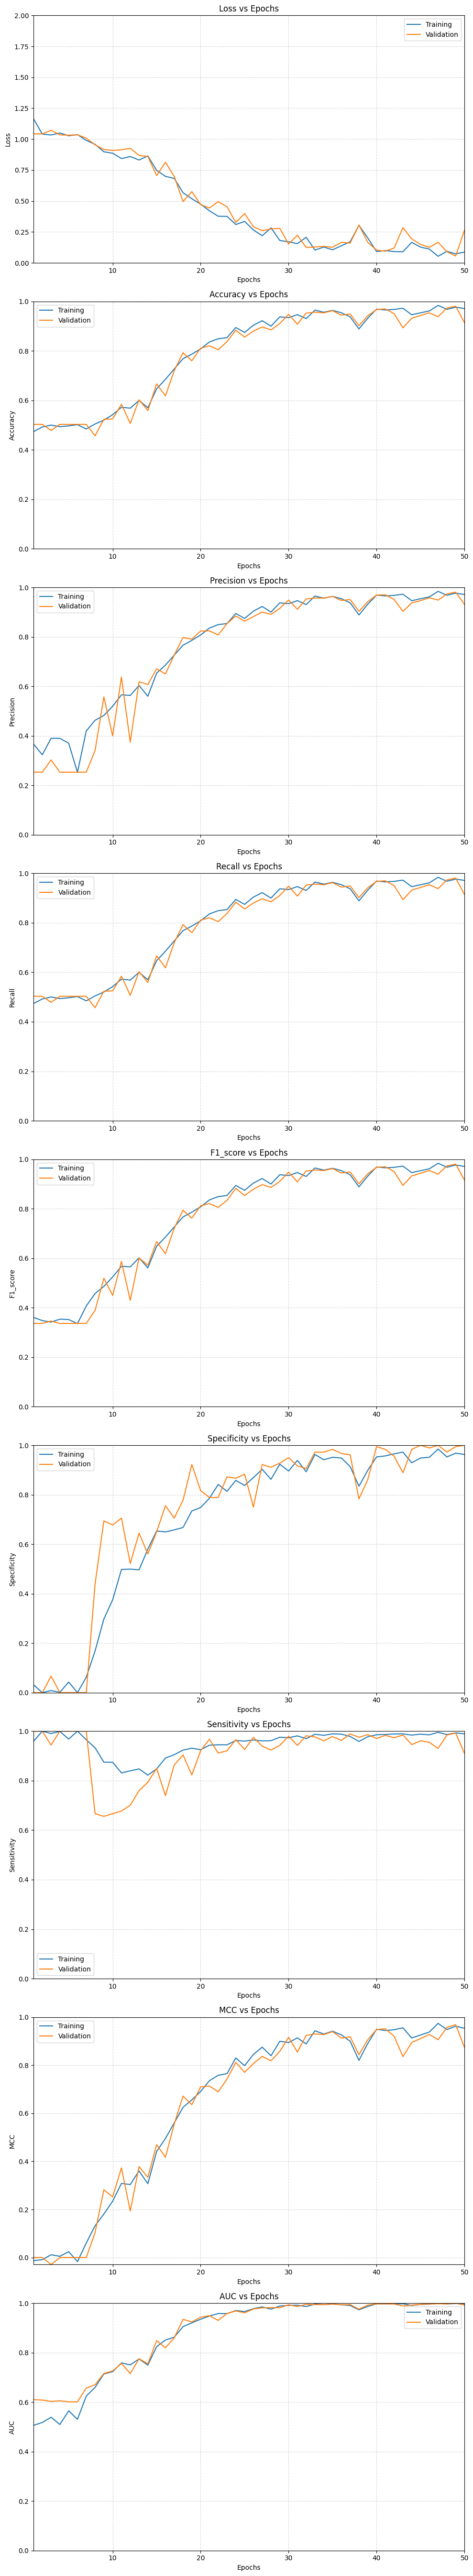

In [59]:
def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        train_metrics_history: a dictionary containing training metrics history
        val_metrics_history: a dictionary containing validation metrics history
        metric_names: a list of strings representing the names of the metrics to plot

    Returns:
        None
    """
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))

    rng = range(1, num_epochs + 1)

    for ax, metric_name in zip(axes, metric_names):
        train_metric = train_metrics_history[metric_name]
        val_metric = val_metrics_history[metric_name]

        ax.plot(rng, train_metric, label="Training")
        ax.plot(rng, val_metric, label="Validation")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_name in ("auc", "mcc"):
            ax.set_ylabel(metric_name.upper())
            ax.set_title(metric_name.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_name.capitalize())
            ax.set_title(metric_name.capitalize() + " vs Epochs")

        max_metric = max(max(train_metric), max(val_metric))
        min_metric = min(min(train_metric), min(val_metric))
        y_max = math.ceil(max_metric)

        if min_metric > 0 or max_metric > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_metric, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, num_epochs)

    plt.tight_layout()
    plt.show()

plot_metrics(train_metrics_history, val_metrics_history, metric_names)